# Contents
- [Background (Separate Notebook)](clean.ipynb)
- [Data Cleaning (Separate Notebook)](clean.ipynb)
- [Exploratory Data Analysis (Separate Notebook)](clean.ipynb)
- [Modelling](#modelling)
- [Conclusion](#conclusion)

Due to the complexity of the data and length of analysis required, the data cleaning and EDA process is split into a separate notebook as linked.

# Modelling
---
As we are trying to predict sale price, a continuous variable, We will be utilising three regression models: `Linear`, `Ridge` and `Lasso` models for this project.

The Dummy Regressor with the mean saleprice value will serve as a simple baseline for comparison. However, to recap our problem statement, our target is to achieve `at least 80% accuracy` in predicting sale price of a property.

Steps:
1. Based on the features identified, we will prepare our features matrix (`X`) and target vector (`y`).
1. We will use the `train-test-split` function to split our X and y variables into a training set and a holdout set. The holdout set will be used to test our model performance.
1. As we have a mix of categorical and numerical features, we will utilise a `ColumnTransformer` together with `Pipelines` to transform the different features:
    - We will utilise the `SimpleImputer` to replace NA values in categorical features and the `KNNImputer` to replace missing values in numerical features.
    - We will utilise the `OrdinalEncoder` and `OneHotEncoder` to convert our ordinal and nominal features respectively.
    - Since we are also using Lasso and Ridge models, we will scale our numerical features using `RobustScaler`.
1. We will contain our `ColumnTransformer` and model within a pipeline. This also allows us to perform grid searching to optimise our model performance.
1. Based on the performance with the training and holdout set, we will select the model with the lowest `RMSLE` score as our model.
1. We will optimise our model using `GridSearchCV` and refit on the full X array to get our optimised model.
1. We will use the optimised model to `predict` the target sale price from the test dataset.

In [4]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# import required sklearn functions for preprocessing and modelling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

import warnings
warnings.filterwarnings('ignore') # hide warnings to avoid cluttering the notebook output

In [5]:
# transfer functions from cleaning notebook
def prep_data(dataframe):
    # convert column names to snake_case
    dataframe.columns = dataframe.columns.str.lower().str.replace(" ", "_")  

    # rename some columns for ease of interpretation
    dataframe.rename(columns={
        "exterior_1st": "exterior", 
        "foundation": "foundation_pconc"
        }, inplace=True
    )

    # create new feature "total_built_area"
    dataframe["total_built_area"] = (
        dataframe["garage_area"]
        + dataframe["open_porch_sf"]
        + dataframe["pool_area"]
        + dataframe["screen_porch"]
        + dataframe["3ssn_porch"]
        + dataframe["enclosed_porch"]
        + dataframe["wood_deck_sf"]
        + dataframe["gr_liv_area"]
    )

    # create new feature "baths"
    dataframe["baths"] = (
        dataframe["bsmt_full_bath"]
        + dataframe["bsmt_half_bath"]
        + dataframe["full_bath"]
        + dataframe["half_bath"]
    )
    
    # convert "foundation" to binary feature
    dataframe["foundation_pconc"] = np.where(dataframe["foundation_pconc"] == "PConc", 1, 0)

In [6]:
df = pd.read_csv("../datasets/train.csv")

# rename columns and engineer new required features
prep_data(df)

# drop 2 identified outliers from the train dataset
df.drop([960, 1885], inplace=True)

f_nominal = [
    'exterior', # renamed from exterior_1st
    'garage_type',
    'house_style',
    'mas_vnr_type',
    ]

f_ordinal = [
    'fireplace_qu',
    'garage_finish',
    'overall_qual',
    ]

f_numeric = [
    'baths',
    'total_built_area',
    'foundation_pconc' # renamed from foundation
    ]

features = f_nominal + f_ordinal + f_numeric


In [7]:
# confirm features to utilise in our model
print(f"{len(f_nominal)} Nominal features: {f_nominal}\n")
print(f"{len(f_ordinal)} Ordinal features: {f_ordinal}\n")
print(f"{len(f_numeric)} Numeric features: {f_numeric}\n")

4 Nominal features: ['exterior', 'garage_type', 'house_style', 'mas_vnr_type']

3 Ordinal features: ['fireplace_qu', 'garage_finish', 'overall_qual']

3 Numeric features: ['baths', 'total_built_area', 'foundation_pconc']



## Prepare Features Matrix and Target Vector

In [8]:
X = df[features]
# apply binary log to saleprice
y = df["saleprice"].map(np.log2)

X.shape

(2049, 10)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Prepare Transformers
---

In [10]:
# define imputers
si = SimpleImputer(strategy="constant", fill_value="None")
knn = KNNImputer(n_neighbors=3, weights="uniform")

# define scalers
rs = RobustScaler()
mm = MinMaxScaler()

In [11]:
# define encoders
ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="ignore")

# specified order for ordinal encoding in ascending order
quality_cat = ["None", "Po", "Fa", "TA", "Gd", "Ex"]
finish_cat = ["None", "Unf", "RFn", "Fin"]
overall_cat = np.arange(1, 11)

oe = OrdinalEncoder(
    categories=[
        quality_cat,  # fireplace_qu
        finish_cat,  # garage_finish
        overall_cat,  # overall_qual
    ],
    dtype=int,
    handle_unknown="error",
)

In [12]:
# set up pipelines for each feature type so they are transformed in sequence

# replace missing values with "None", then perform OneHotEncoding
nominal_pipe = Pipeline([('impute', si), ('encode', ohe)])
# replace missing values with "None", perform OrdinalEncoding then scale
ordinal_pipe = Pipeline([('impute', si), ('encode', oe), ('scale', rs)])
# impute based on 5 nearest neighbours, then scale
numeric_pipe = Pipeline([('impute', knn), ('scale', rs)]) 

In [13]:
# set up ColumnTransformer to handle different preprocessing methods for different feature types
ct = ColumnTransformer(
                    transformers=[
                        ('nom', nominal_pipe, f_nominal),
                        ('ord', ordinal_pipe, f_ordinal),
                        ('num', numeric_pipe, f_numeric)
                    ],
                    remainder='drop',
                    n_jobs=-1
                    )

## Model Prep: Instantiate our models
---

We'll be evaluating `Linear`, `Lasso` and `Ridge` Regression models, so we'll need to create instances of all three models. We will utilise LassoCV and RidgeCV to identify an optimal alpha value through cross validation for use in our final prediction model.

In [14]:
dr = DummyRegressor()

lr = LinearRegression()

# utilise LassoCV to find an optimal value for alpha
lcv = LassoCV(n_alphas=300)

# utilise RidgeCV to find an optimal value for alpha
rcv = RidgeCV(alphas=np.linspace(.1, 50, 300))

In [15]:
# utilise pipelines to process data before modelling and allow for hyperparameter tuning
dummy_pipe = Pipeline([
     ("ct", ct), ("dummy", dr)
     ])

lr_pipe = Pipeline([
     ("ct", ct), ("linear", lr)
     ])

lasso_pipe = Pipeline([
     ("ct", ct), ("lasso", lcv)
     ])

ridge_pipe = Pipeline([
     ("ct", ct), ("ridge", rcv)
     ])

## Model Evaluation

We will utilise the `cross_val_score` function within the sklearn library to perform 5 fold cross validation to check for generalisation performance, scored by Root Mean Squared Logarithmic Error (RMSLE), as our target variable has been log-transformed.

In [16]:
# prepare model scorer with root mean square logarithmic error (RMSLE)
# scorer will return logarithmic error as our target variable has been log transformed
rmse_scorer = make_scorer(mean_squared_error, squared=False)

In [17]:
# create baseline for comparison

# RMSE
dummy_rmse = cross_val_score(dummy_pipe, X_train, y_train, error_score="raise", cv=5, scoring=rmse_scorer)
print(f"Dummy Regression mean RMLSE score: {dummy_rmse.mean()}")
print(f"Percentage error: {(2 ** dummy_rmse.mean() - 1) * 100}")

# R2
dummy_r2 = cross_val_score(dummy_pipe, X_train, y_train, error_score="raise", cv=5)
print(f"Dummy Regression mean R2 score: {dummy_r2.mean()}")

Dummy Regression mean RMLSE score: 0.5896642565569099
Percentage error: 50.48964877162769
Dummy Regression mean R2 score: -0.0007119865619534593


In [18]:
# Generate the cross_val score for LR fitted to train data
# RMSE
lr_rmse = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring=rmse_scorer)
print(f"Linear Regression mean RMLSE score: {lr_rmse.mean()}")
print(f"Percentage error: {(2 ** lr_rmse.mean() - 1) * 100}")

# R2
lr_r2 = cross_val_score(lr_pipe, X_train, y_train, cv=5)
print(f"Linear Regression mean R2 score: {lr_r2.mean()}")

Linear Regression mean RMLSE score: 0.2352640769852626
Percentage error: 17.71221829093306
Linear Regression mean R2 score: 0.8395640823066094


In [19]:
# Generate the cross_val score for Lasso CV (i.e. with optimal alpha value) fitted to train data
# RMSE
lasso_rmse = cross_val_score(lasso_pipe, X_train, y_train, cv=5, scoring=rmse_scorer)
print(f"Lasso Regression mean RMLSE score: {lasso_rmse.mean()}")
print(f"Percentage error: {(2 ** lasso_rmse.mean() - 1) * 100}")

# R2
lasso_r2 = cross_val_score(lasso_pipe, X_train, y_train, cv=5)
print(f"Linear Regression mean R2 score: {lasso_r2.mean()}")

# alpha
lasso_pipe.fit(X_train, y_train)
lasso_alpha = lasso_pipe[-1].alpha_
print(f"Optimal alpha: {lasso_alpha}")

Lasso Regression mean RMLSE score: 0.23164611399740012
Percentage error: 17.417391679527473
Linear Regression mean R2 score: 0.8444219535528582
Optimal alpha: 0.0007969275754195895


In [20]:
# Generate the cross_val score for Ridge CV (i.e. with optimal alpha value) fitted to train data
# RMSE
ridge_rmse = cross_val_score(ridge_pipe, X_train, y_train, cv=5, scoring=rmse_scorer)
print(f"Ridge Regression mean RMLSE score: {ridge_rmse.mean()}")
print(f"Percentage error: {(2 ** ridge_rmse.mean() - 1) * 100}")

# R2
ridge_r2 = cross_val_score(ridge_pipe, X_train, y_train, cv=5)
print(f"Linear Regression mean R2 score: {ridge_r2.mean()}")

# alpha
ridge_pipe.fit(X_train, y_train)
ridge_alpha = ridge_pipe[-1].alpha_
print(f"Optimal alpha: {ridge_alpha}")

Ridge Regression mean RMLSE score: 0.23259211467332447
Percentage error: 17.49440958993911
Linear Regression mean R2 score: 0.8430302219120718
Optimal alpha: 3.1040133779264214


### Check Coefficients
---
The coefficients from the Lasso Model provides an insight into features that may not be very useful in our predictions and are hence zero-ed out by the model. At the same time, we can identify which features have a higher impact on our predictions based on the magnitude of the coefficients.

In [45]:
# create a function for combining feature names and regression model coefficients
def find_coef(pipeline):
    # identifying the feature names
    nom_headers = list(pipeline[0].transformers_[0][1][1].get_feature_names_out(f_nominal))
    ord_headers = f_ordinal
    num_headers = f_numeric
    headers = nom_headers + ord_headers + num_headers
    # extracting the coef from the model
    values = pipeline[1].coef_
    # combine into a dataframe
    cdf = pd.DataFrame(index=headers, data=values, columns=["coef"])
    cdf['inverse'] = cdf['coef'].apply(lambda x: (((2 ** x) - 1) * 100))
    cdf["abs"] = cdf['inverse'].map(abs)
    cdf_filtered = cdf[cdf["abs"] != 0].sort_values(by="abs", ascending=False)
    colors = ["royalblue" if val > 0 else "indianred" for val in cdf_filtered["inverse"]]
    
    # plot coefficients into a chart
    plt.figure(figsize=(10, 8))
    sns.barplot(data=cdf_filtered, y=cdf_filtered.index, x=cdf_filtered['inverse'], palette=colors, order=cdf_filtered.index);
    plt.title(f"Coefficients of Lasso Regression (Alpha: {lasso_alpha:.5f})", fontsize=20)
    plt.ylabel("Features", fontsize=15)
    plt.xlabel("Coefficients (% Change)", fontsize=15)

    return cdf

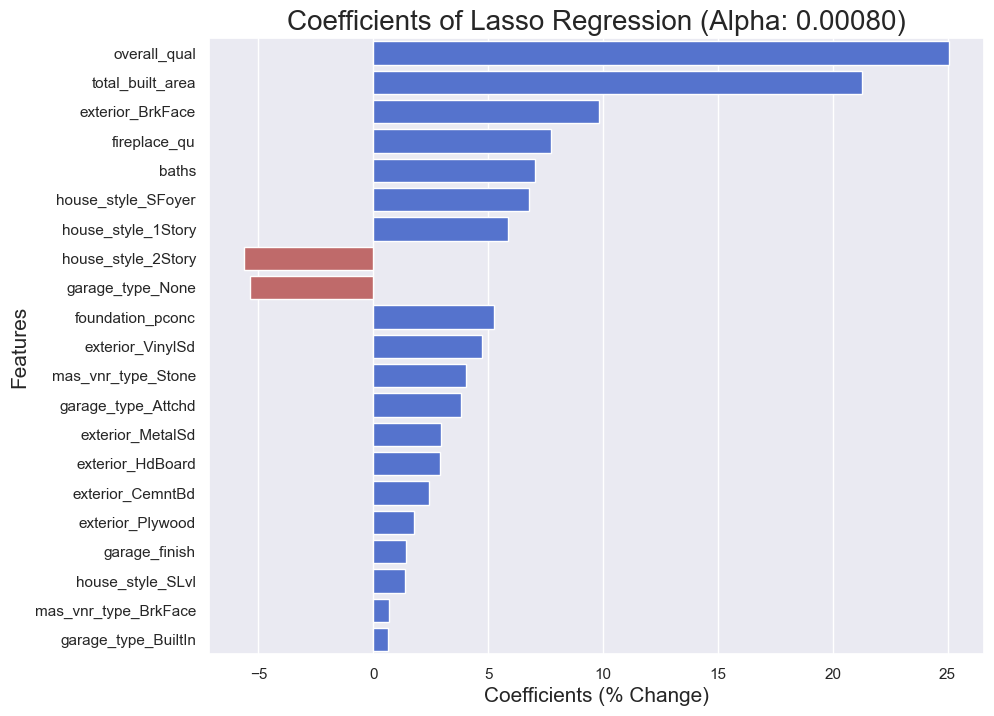

In [46]:
l_coef = find_coef(lasso_pipe)

Based on the chart above, we see that the overall quality of the house contributes greatly to the saleprice of a property. In fact, a single grade difference in overall quality would contribute to an almost 25% change in sale price! This would definitely be a key factor that our agents must look out for when performing any appraisals.

Some key insights:

> **For home sellers**
> - Fireplace quality, number of bathrooms and garage finish are features that owners could improve upon prior to sale so as to increase the potential sale price.
> - For a single grade increase in fireplace quality, we would expect at least a 5% increase in sale price
> - To maximise selling potential, agents can assess the current condition of the properties, obtain quotations from our partner contractors and present the cost-benefit analysis to our clients to determine if they would want to pay for upgrades prior to sale

> **For home buyers**
> - Overall quality of the house is a very important factor to assess when purchasing a home.
> - Depending on the available budget of our clients, agents can identify whether a property is potentially under or overpriced, as well as identify if there are opportunities to negotiate a better deal based on certain features of the house (or lack thereof).
> - For example, home owners on a tighter budget could consider properties without a garage, allowing them to potentially cut 5% off the price. 

In [38]:
# percentage of variables zeroed out by Lasso
print(f"Percentage values zeroed out: {len(l_coef[l_coef['coef'] == 0]) / len(l_coef)}")

l_coef[(l_coef['inverse'] == 0)].sort_values(by="abs")

Percentage values zeroed out: 0.4166666666666667


,coef,inverse,abs
exterior_AsphShn,0.0,0.0,0.0
exterior_BrkComm,-0.0,0.0,0.0
exterior_CBlock,-0.0,0.0,0.0
exterior_ImStucc,0.0,0.0,0.0
exterior_Stone,0.0,0.0,0.0
exterior_Stucco,-0.0,0.0,0.0
exterior_Wd Sdng,-0.0,0.0,0.0
exterior_WdShing,0.0,0.0,0.0
garage_type_Basment,-0.0,0.0,0.0
garage_type_CarPort,-0.0,0.0,0.0


### Model Selection
---
Tabulating the results of our modelling:

|Model|RMLSE Mean|Percentage Error|R2|
|:---|---:|---:|---:|
|Dummy|0.5897|50.49%|-0.0007|
|Linear|0.2353|17.71%|0.8396|
|**Lasso**|**0.2316**|**17.42%**|**0.8444**|
|Ridge|0.2326|17.49%|0.0.8430|

`Lasso` model has the lowest RMLSE based on our train data. This suggests that the model is most accurate in predicting the sale price with the lowest percentage difference from the actual price. For any prediction, the model may have an error of about 17%.

Using the Lasso model, we will fit the model with our full train data and attempt to perform a prediction with an unseen test set provided by the agency.

In [24]:
lasso = Lasso(alpha=lasso_alpha)

In [25]:
model = Pipeline([
     ("ct", ct),
     ("model", lasso)
])

In [26]:
model.fit(X, y);

In [27]:
print(f"X_train R2 score: {model.score(X_train, y_train)}")
print(f"X_test R2 score: {model.score(X_test, y_test)}")
print(f"X R2 score: {model.score(X, y)}")

X_train R2 score: 0.8507767309022647
X_test R2 score: 0.8441305202690816
X R2 score: 0.8489243140403369


In [28]:
model_preds = model.predict(X)

# convert y and predictions back from log 2
print(f"RMSE: {mean_squared_error(2 ** y, 2 ** model_preds, squared=False)}")

RMSE: 27354.688973103344


The optimised model has a $R^2$ close to 1.0 with both the train (`0.85`) and holdout sets (`0.84`), with around 0.01 difference between the two sets. This suggests our model is not over or under fitted and will perform well with unseen data.

Using this final model, we achieve a RMSE of 27354, suggesting that the model is accurate in predicting the sale price of a property within $27,354 of the actual price around 85% of the time.

### Model Optimisation
---
We will plot our predicted values against the actual saleprice to check our model accuracy.

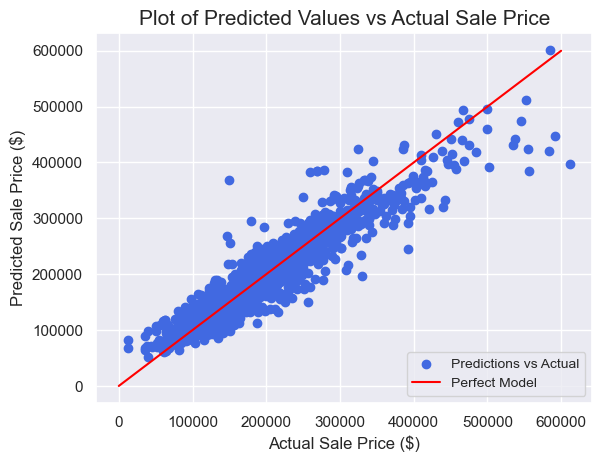

In [48]:
plt.scatter(x=df["saleprice"], y=2 ** model_preds, color="royalblue", label="Predictions vs Actual")
plt.plot([0,600000], [0,600000], color='red', label="Perfect Model")
plt.title("Plot of Predicted Values vs Actual Sale Price", fontsize=15)
plt.ylabel("Predicted Sale Price ($)")
plt.xlabel("Actual Sale Price ($)")
plt.legend(loc="lower right", fontsize=10);

Based on the plot above, we see that the model generally performs well and the predictions are centred around the "perfect model", represented by the red line. However, there are still some outliers in our predictions especially for the higher end properties, which suggests that there is still room for improvement.

In [30]:
# attempt to optimise the model
parameters = {
	'ct__nom__encode__drop': ("first", None),
	'ct__num__impute__n_neighbors': (1, 3, 5, 7, 10),
	'ct__num__impute__weights': ("uniform", "distance"),
	'ct__num__scale' : (rs, mm)
	# 'ct__nom__si': (si, knn),
	# 'ct__ord__si': (si, knn)
}

In [31]:
grid = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    cv=10,
    error_score="raise",
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1,
)


In [32]:
# grid.get_params().keys()

In [33]:
grid.fit(X, y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('nom',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(fill_value='None',
                                                                                                        strategy='constant')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                   

In [34]:
grid.best_params_

{'ct__nom__encode__drop': 'first',
 'ct__num__impute__n_neighbors': 1,
 'ct__num__impute__weights': 'uniform',
 'ct__num__scale': MinMaxScaler()}

In [35]:
grid.best_score_

0.2305781305769136

## Prediction
---
As a final evaluation of our model, we will perform a set of predictions on an unseen set of data provided by the agency. This set of test data is extracted from the same time period, but withheld from the model.

Once the predictions have been made, we will submit the predictions into an online portal "Kaggle", which will compare the predictions against the actual sale price and return us our RMSE performance.

In [36]:
test_set = pd.read_csv("../datasets/test.csv")
prep_data(test_set)

In [37]:
# reverse binary log
results = 2 ** model.predict(test_set)

# combine the predictions with the id column of the test data, then export to csv
results_df = test_set[["id"]].merge(
    pd.DataFrame(results), left_index=True, right_index=True
)
results_df.to_csv("../predictions.csv", header=["Id", "SalePrice"], index=False)

Based on the Kaggle dashboard, the model has performed reasonably well and our predictions are within the range of around $25,000 - $27,000 from the actual sale price.

![Kaggle Score](../images/prediction_score.png)

# Conclusion
---


## Recommendations
Due to limitations with time and resources, we have committed to an initial proof of concept with our prediction model based on available data. However, there are some future work that would be required to maximise the full potential of our model's predictive abilities.

- **Retrain the model with newer datasets once available.**<br>
Due to the limitations with the currently available data, the prediction model is trained on a set of outdated information from 2006 - 2010. There would likely have various changes that have happened since, for example the availability of new building raw materials or building techniques, or maybe even demographic changes that affect the demand for housing types.<br><br>
As the remaining transactions are being digitalised, we can load the data into our model progressively and also start to identify if there may have been any trends over the years. Once all the data is complete, we can perform a final analysis and confirm the performance of our prediction model based on up-to-date information.

- **Further research into price difference between neighbourhoods**<br>
From our analysis, we identified that there may be missing information in our data that is unable to account for the price difference between the various neighbourhoods. While it may be common knowledge among real estate agents that properties in certain areas fetch higher prices, we will want to dive deeper into the underlying reasons in order to be able to accurately predict the expected sale price.<br><br>
If time and resources allow, we can commission a more detailed study on the respective neighbourhoods in Ames to identify if there are any other reasons that contribute to their housing sale prices.

- **Development of real-time prediction tool accessible via mobile app**<br>
Concurrent to the above steps, the agency can also consider engaging a software development team to build a mobile app that our agents can have access to while on the go. This would allow them to perform real-time grading and price predictions for clients once the prediction model has been refined with up-to-date data.<br><br>
As the agency seeks to expand to other cities and states in the US, the model can also be trained using data from other cities to likewise perform predictions for real estate agents stationed in those areas.